In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import seaborn as sns
import mudata as md
import networkx as nx
import matplotlib.pyplot as plt

import gc
import sys
sys.path.append('../')

from utils.gglasso_pipeline import gg_lasso_network_analysis
from utils.utils import calc_sparsity
from latentcor import latentcor

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

### Efm

In [2]:
efm_mudata = md.read("../data/preprocessed/efm_mudata_preprocessed.h5mu")
efm_mudata

c:\Users\Jan\.conda\envs\bacdrop\lib\site-packages\mudata\_core\mudata.py:491: UserWarning: Cannot join columns with the same name because var_names are intersecting.
  warnings.warn(


MuData object with n_obs × n_vars = 4708 × 2530
  3 modalities
    all_genes:	4708 x 2186
      obs:	'strains', 'n_genes_by_counts', 'total_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'total_counts_rRNA', 'log1p_total_counts_rRNA', 'pct_counts_rRNA', 'outlier', 'n_counts'
      var:	'strains', 'matchin_protein', 'protein', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'protein_name', 'rRNA', 'PC_lev0', 'PC_lev1', 'PC_lev2', 'PC_lev3', 'PC_lev4', 'PC_lev5', 'PC_lev6', 'log1p_mean_counts', 'log1p_total_counts', 'n_counts'
      uns:	'genes_match', 'protein_match', 'unmatch_genes'
      layers:	'log1p', 'norm_counts', 'raw_counts', 'sqrt_counts'
    gc1_genes:	4708 x 286
      obs:	'strains', 'n_genes_by_counts', 'total_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'total_counts_rRNA', 'log1p_total_counts_rRNA', 'pct_counts_rRNA', 'outlier', 'n_counts'
      var:	'strains', 'matchin_protein', 'protein', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'protein_name', 'rRNA', 'PC_lev0', 'PC_lev1', 'PC_lev2', 'PC_lev3', 'PC_lev4', 'PC_lev5', 'PC_lev6', 'log1p_mean_counts', 'log1p_total_counts', 'n_counts'
      uns:	'genes_match', 'protein_match', 'unmatch_genes'
      layers:	'log1p', 'norm_counts', 'raw_counts', 'sqrt_counts'
    gc5_genes:	4701 x 58
      obs:	'strains', 'n_genes_by_counts', 'total_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'total_counts_rRNA', 'log1p_total_counts_rRNA', 'pct_counts_rRNA', 'outlier', 'n_counts'
      var:	'strains', 'matchin_protein', 'protein', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'protein_name', 'rRNA', 'PC_lev0', 'PC_lev1', 'PC_lev2', 'PC_lev3', 'PC_lev4', 'PC_lev5', 'PC_lev6', 'log1p_mean_counts', 'log1p_total_counts', 'n_counts'
      uns:	'genes_match', 'protein_match', 'unmatch_genes'
      layers:	'log1p', 'norm_counts', 'raw_counts', 'sqrt_counts'

In [3]:
print("Sparsity:\t\t", calc_sparsity(efm_mudata["gc5_genes"].X.A))
print("Mean counts per gene:\t", np.mean(np.sum(efm_mudata["gc5_genes"].X.A, axis=1)))
print("Median counts per gene:\t", np.median(np.sum(efm_mudata["gc5_genes"].X.A, axis=1)))
print("Mean genes per cell: \t", np.mean(np.sum(efm_mudata["gc5_genes"].X.A, axis=0)))
print("Median genes per cell:\t", np.median(np.sum(efm_mudata["gc5_genes"].X.A, axis=0)))

Sparsity:		 0.877868978720595
Mean counts per gene:	 8.284408
Median counts per gene:	 7.0
Mean genes per cell: 	 671.4655
Median genes per cell:	 479.5


c:\Users\Jan\.conda\envs\bacdrop\lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
c:\Users\Jan\.conda\envs\bacdrop\lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


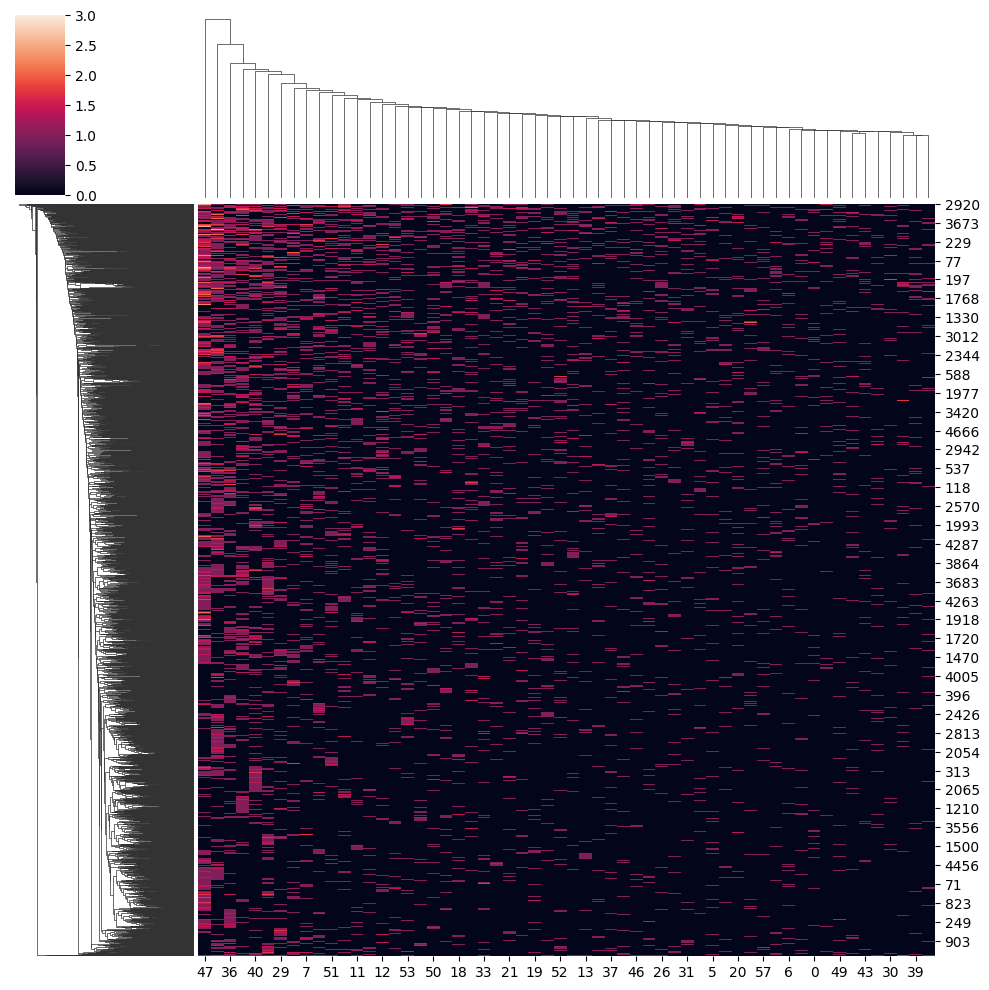

In [4]:
sns.clustermap(efm_mudata["gc5_genes"].layers['sqrt_counts'].A)

## mRNA analysis

In [5]:
efm_mudata["gc5_genes"].var["rRNA"].value_counts()

rRNA
False    33
True     25
Name: count, dtype: int64

In [8]:
efm_mrna = efm_mudata["gc5_genes"][:, ~efm_mudata["gc5_genes"].var["rRNA"]].copy()
efm_mrna

AnnData object with n_obs × n_vars = 4701 × 33
    obs: 'strains', 'n_genes_by_counts', 'total_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'total_counts_rRNA', 'log1p_total_counts_rRNA', 'pct_counts_rRNA', 'outlier', 'n_counts'
    var: 'strains', 'matchin_protein', 'protein', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'protein_name', 'rRNA', 'PC_lev0', 'PC_lev1', 'PC_lev2', 'PC_lev3', 'PC_lev4', 'PC_lev5', 'PC_lev6', 'log1p_mean_counts', 'log1p_total_counts', 'n_counts'
    uns: 'genes_match', 'protein_match', 'unmatch_genes'
    layers: 'log1p', 'norm_counts', 'raw_counts', 'sqrt_counts'

In [9]:
efm_rrna = efm_mudata["gc5_genes"][:, efm_mudata["gc5_genes"].var["rRNA"]].copy()
efm_rrna

AnnData object with n_obs × n_vars = 4701 × 25
    obs: 'strains', 'n_genes_by_counts', 'total_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'total_counts_rRNA', 'log1p_total_counts_rRNA', 'pct_counts_rRNA', 'outlier', 'n_counts'
    var: 'strains', 'matchin_protein', 'protein', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'protein_name', 'rRNA', 'PC_lev0', 'PC_lev1', 'PC_lev2', 'PC_lev3', 'PC_lev4', 'PC_lev5', 'PC_lev6', 'log1p_mean_counts', 'log1p_total_counts', 'n_counts'
    uns: 'genes_match', 'protein_match', 'unmatch_genes'
    layers: 'log1p', 'norm_counts', 'raw_counts', 'sqrt_counts'

### Estimating latent correlation with latentcor

c:\Users\Jan\.conda\envs\bacdrop\lib\site-packages\statsmodels\stats\correlation_tools.py:90: IterationLimitWarning: 
Maximum iteration reached.

  warnings.warn(iteration_limit_doc, IterationLimitWarning)


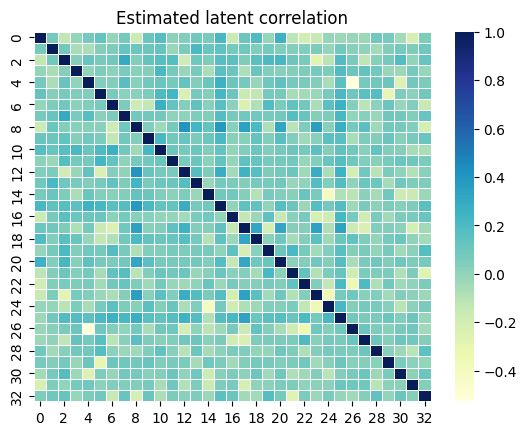

In [10]:
tps = ['tru' for i in range(efm_mrna.shape[1])]
efm_est = latentcor(efm_mrna.layers['sqrt_counts'].A, tps=tps, method='approx', use_nearPD=True, nu=0.001, showplot=True)

### Single Graphical Lasso with GGL
Modelselection for lambda based on eBIC

In [11]:
efm_ggl_latentcor = gg_lasso_network_analysis(N=efm_mrna.shape[0], estimate=efm_est)
efm_ggl_latentcor.create_problem(S_col="R", latent=False)
efm_ggl_latentcor.model_selection(lambda1_range=np.logspace(0, -6, 200))

 
SINGLE GRAPHICAL LASSO PROBLEM 
Regularization parameters:
{'lambda1': 0.05, 'mu1': None}
ADMM terminated after 11 iterations with status: optimal.
ADMM terminated after 10 iterations with status: optimal.
ADMM terminated after 10 iterations with status: optimal.
ADMM terminated after 9 iterations with status: optimal.
ADMM terminated after 13 iterations with status: optimal.
ADMM terminated after 12 iterations with status: optimal.
ADMM terminated after 9 iterations with status: optimal.
ADMM terminated after 27 iterations with status: optimal.
ADMM terminated after 10 iterations with status: optimal.
ADMM terminated after 9 iterations with status: optimal.
ADMM terminated after 27 iterations with status: optimal.
ADMM terminated after 10 iterations with status: optimal.
ADMM terminated after 26 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 26 iterations with status: optimal.
ADMM terminated after 22 iterations with 

In [13]:
efm_sol_latentcor = efm_ggl_latentcor.P.solution.precision_ * -1

<Axes: >

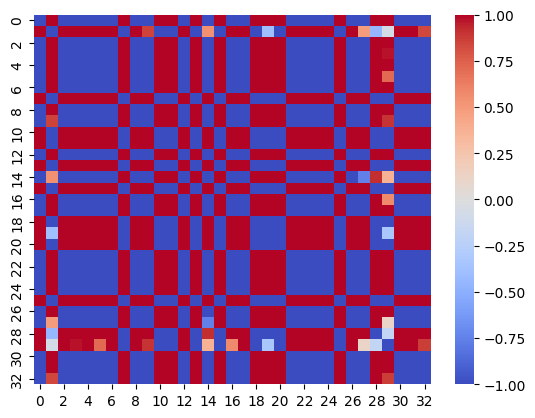

In [14]:
sns.heatmap(efm_sol_latentcor, cmap="coolwarm", vmin=-1, vmax=1)

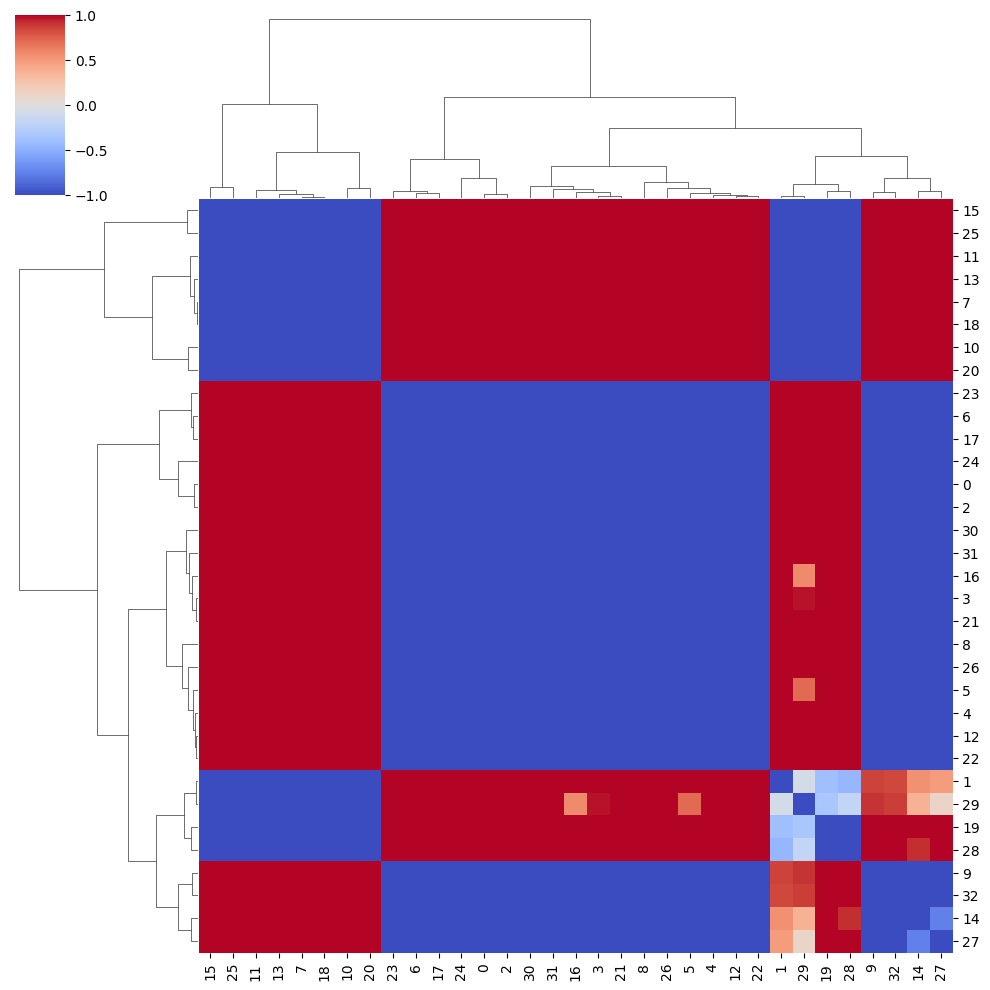

In [15]:
sns.clustermap(efm_sol_latentcor, cmap="coolwarm", vmin=-1, vmax=1)

### Plotting the resulting network

In [16]:
def extract_part(text):
    return ' '.join(text.split()[1:-5])

efm_mrna.var["short_protein_name"] = efm_mrna.var["protein_name"].apply(lambda x: extract_part(x))

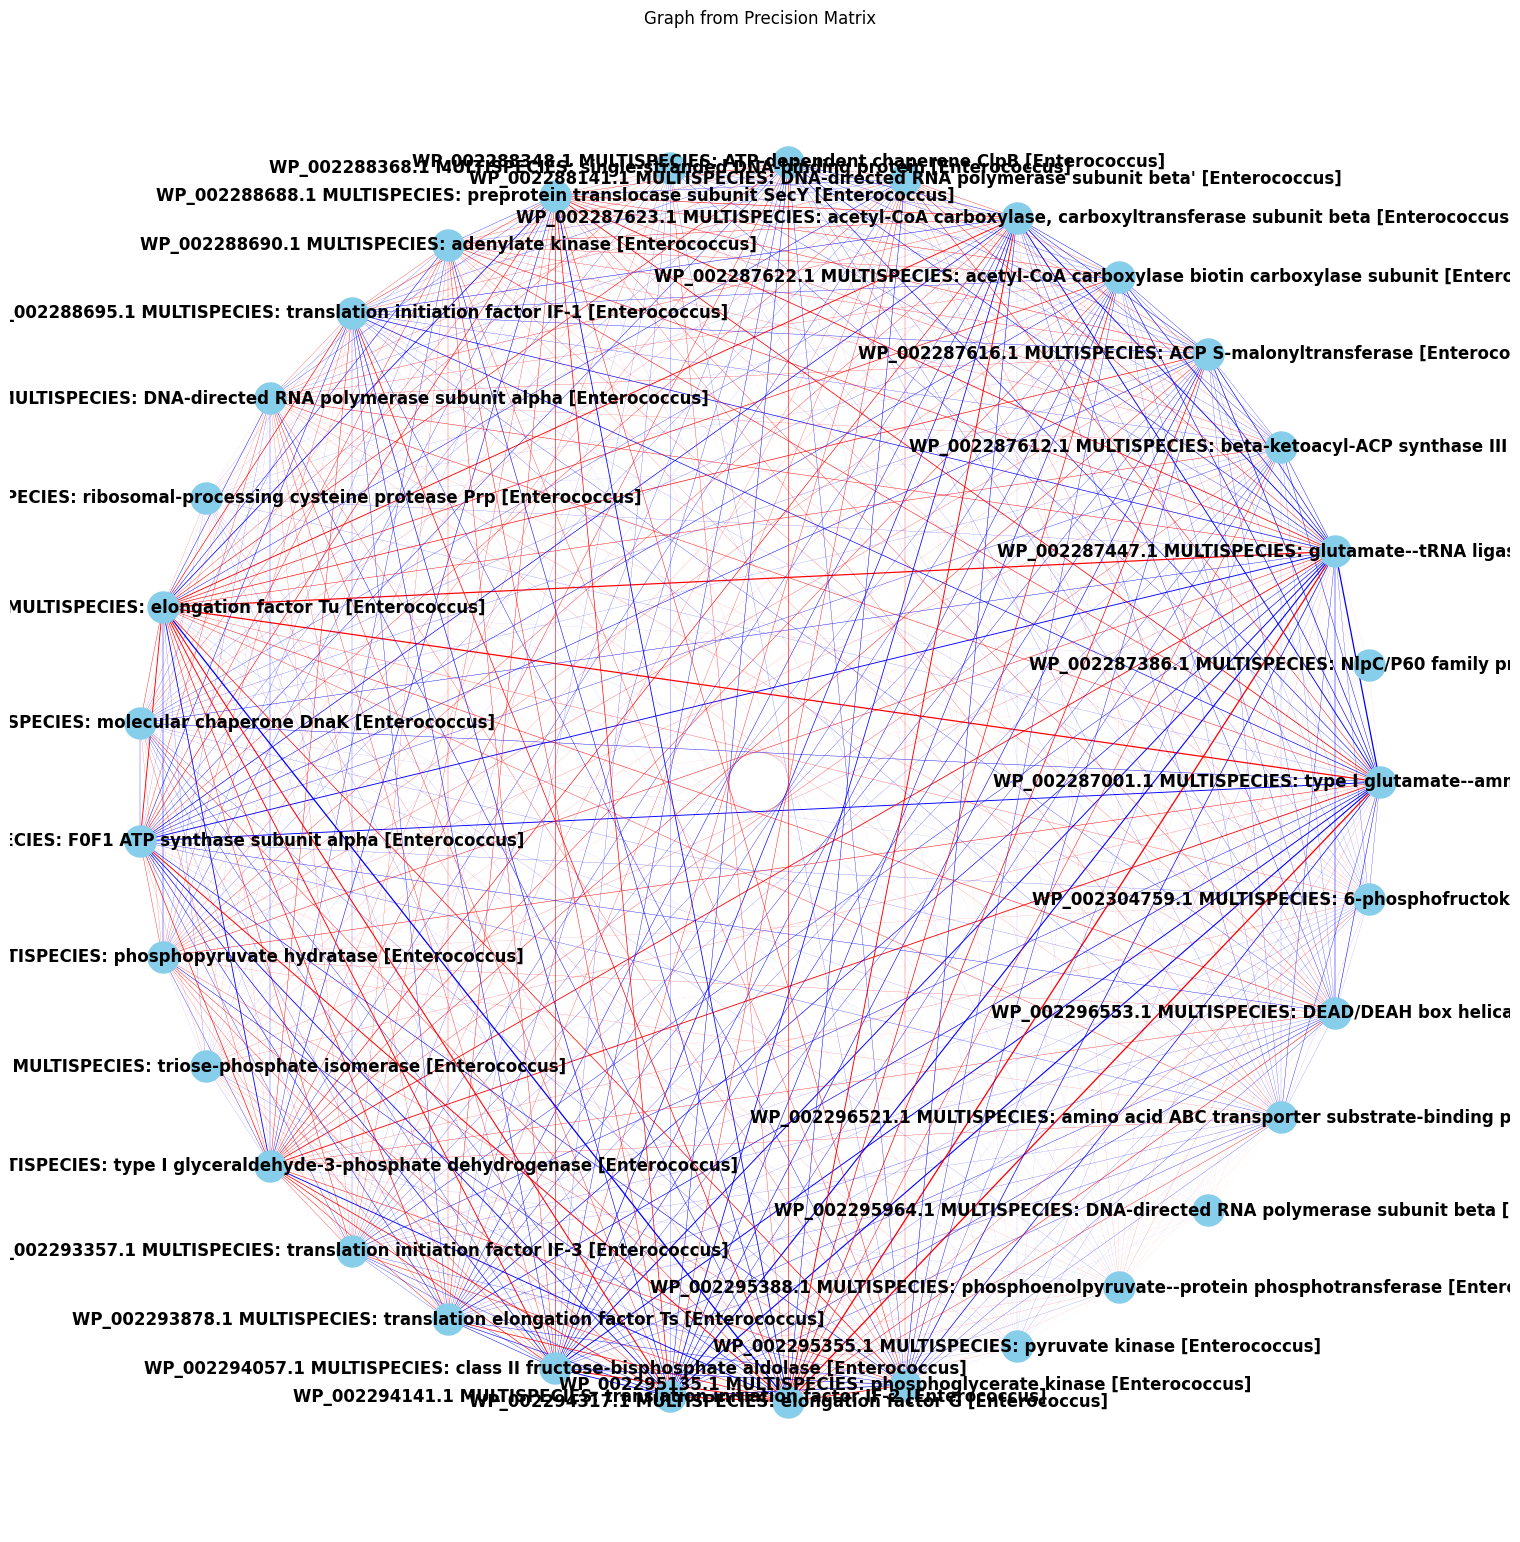

In [20]:
efm_G = nx.Graph()

# Add nodes to the graph
for idx, row in efm_mrna.var.iterrows():
    efm_G.add_node(row['protein_name'])

# Add edges to the graph based on the weights
n = len(efm_mrna.var)
for i in range(n):
    for j in range(i + 1, n):
        weight = efm_sol_latentcor[i, j]
        if weight != 0:
            efm_G.add_edge(efm_mrna.var.iloc[i]['protein_name'], efm_mrna.var.iloc[j]['protein_name'], weight=weight)

# Set edge colors based on weight sign
edge_colors = []
edge_widths = []
for edge in efm_G.edges(data=True):
    weight = edge[2]['weight']
    if weight > 0:
        edge_colors.append('red')  # Positive edge
    elif weight < 0:
        edge_colors.append('blue')  # Negative edge
    edge_widths.append(abs(weight) * 0.01)  # Scale width based on weight


# Draw the graph
pos = nx.circular_layout(efm_G)
plt.figure(figsize=(15, 15))
nx.draw(efm_G, pos, with_labels=True, node_size=500, node_color='skyblue', font_size=12, font_weight='bold', 
        edge_color=edge_colors, width=edge_widths)
plt.title('Graph from Precision Matrix')
plt.show()

## rRNA

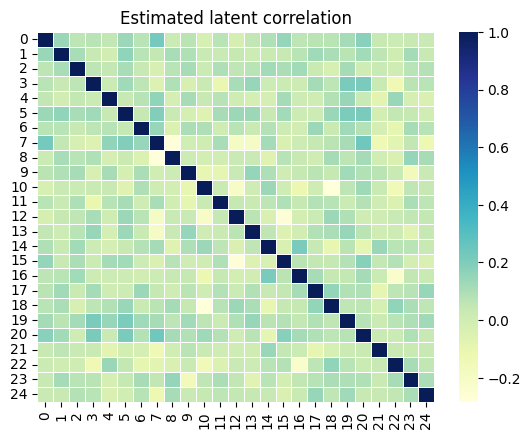

In [21]:
tps = ['tru' for i in range(efm_rrna.shape[1])]
efm_est = latentcor(efm_rrna.layers['sqrt_counts'].A, tps=tps, method='approx', use_nearPD=True, nu=0.001, showplot=True)

In [22]:
efm_rrna_ggl_latentcor = gg_lasso_network_analysis(N=efm_rrna.shape[0], estimate=efm_est)
efm_rrna_ggl_latentcor.create_problem(S_col="R", latent=False)
efm_rrna_ggl_latentcor.model_selection(lambda1_range=np.logspace(0, -6, 200))

 
SINGLE GRAPHICAL LASSO PROBLEM 
Regularization parameters:
{'lambda1': 0.05, 'mu1': None}
ADMM terminated after 11 iterations with status: optimal.
ADMM terminated after 11 iterations with status: optimal.
ADMM terminated after 10 iterations with status: optimal.
ADMM terminated after 10 iterations with status: optimal.
ADMM terminated after 11 iterations with status: optimal.
ADMM terminated after 28 iterations with status: optimal.
ADMM terminated after 9 iterations with status: optimal.
ADMM terminated after 10 iterations with status: optimal.
ADMM terminated after 27 iterations with status: optimal.
ADMM terminated after 9 iterations with status: optimal.
ADMM terminated after 9 iterations with status: optimal.
ADMM terminated after 10 iterations with status: optimal.
ADMM terminated after 21 iterations with status: optimal.
ADMM terminated after 26 iterations with status: optimal.
ADMM terminated after 27 iterations with status: optimal.
ADMM terminated after 21 iterations with 

In [23]:
efm_rrna_sol_latentcor = efm_rrna_ggl_latentcor.P.solution.precision_ * -1

<Axes: >

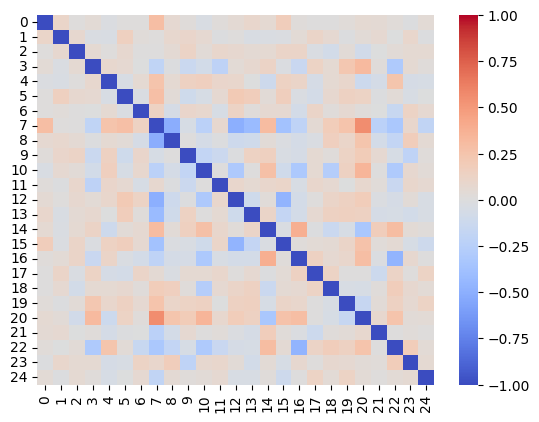

In [24]:
sns.heatmap(efm_rrna_sol_latentcor, cmap="coolwarm", vmin=-1, vmax=1)

In [25]:
def extract_part(text):
    return ' '.join(text.split()[1:-5])

efm_rrna.var["short_protein_name"] = efm_rrna.var["protein_name"].apply(lambda x: extract_part(x))

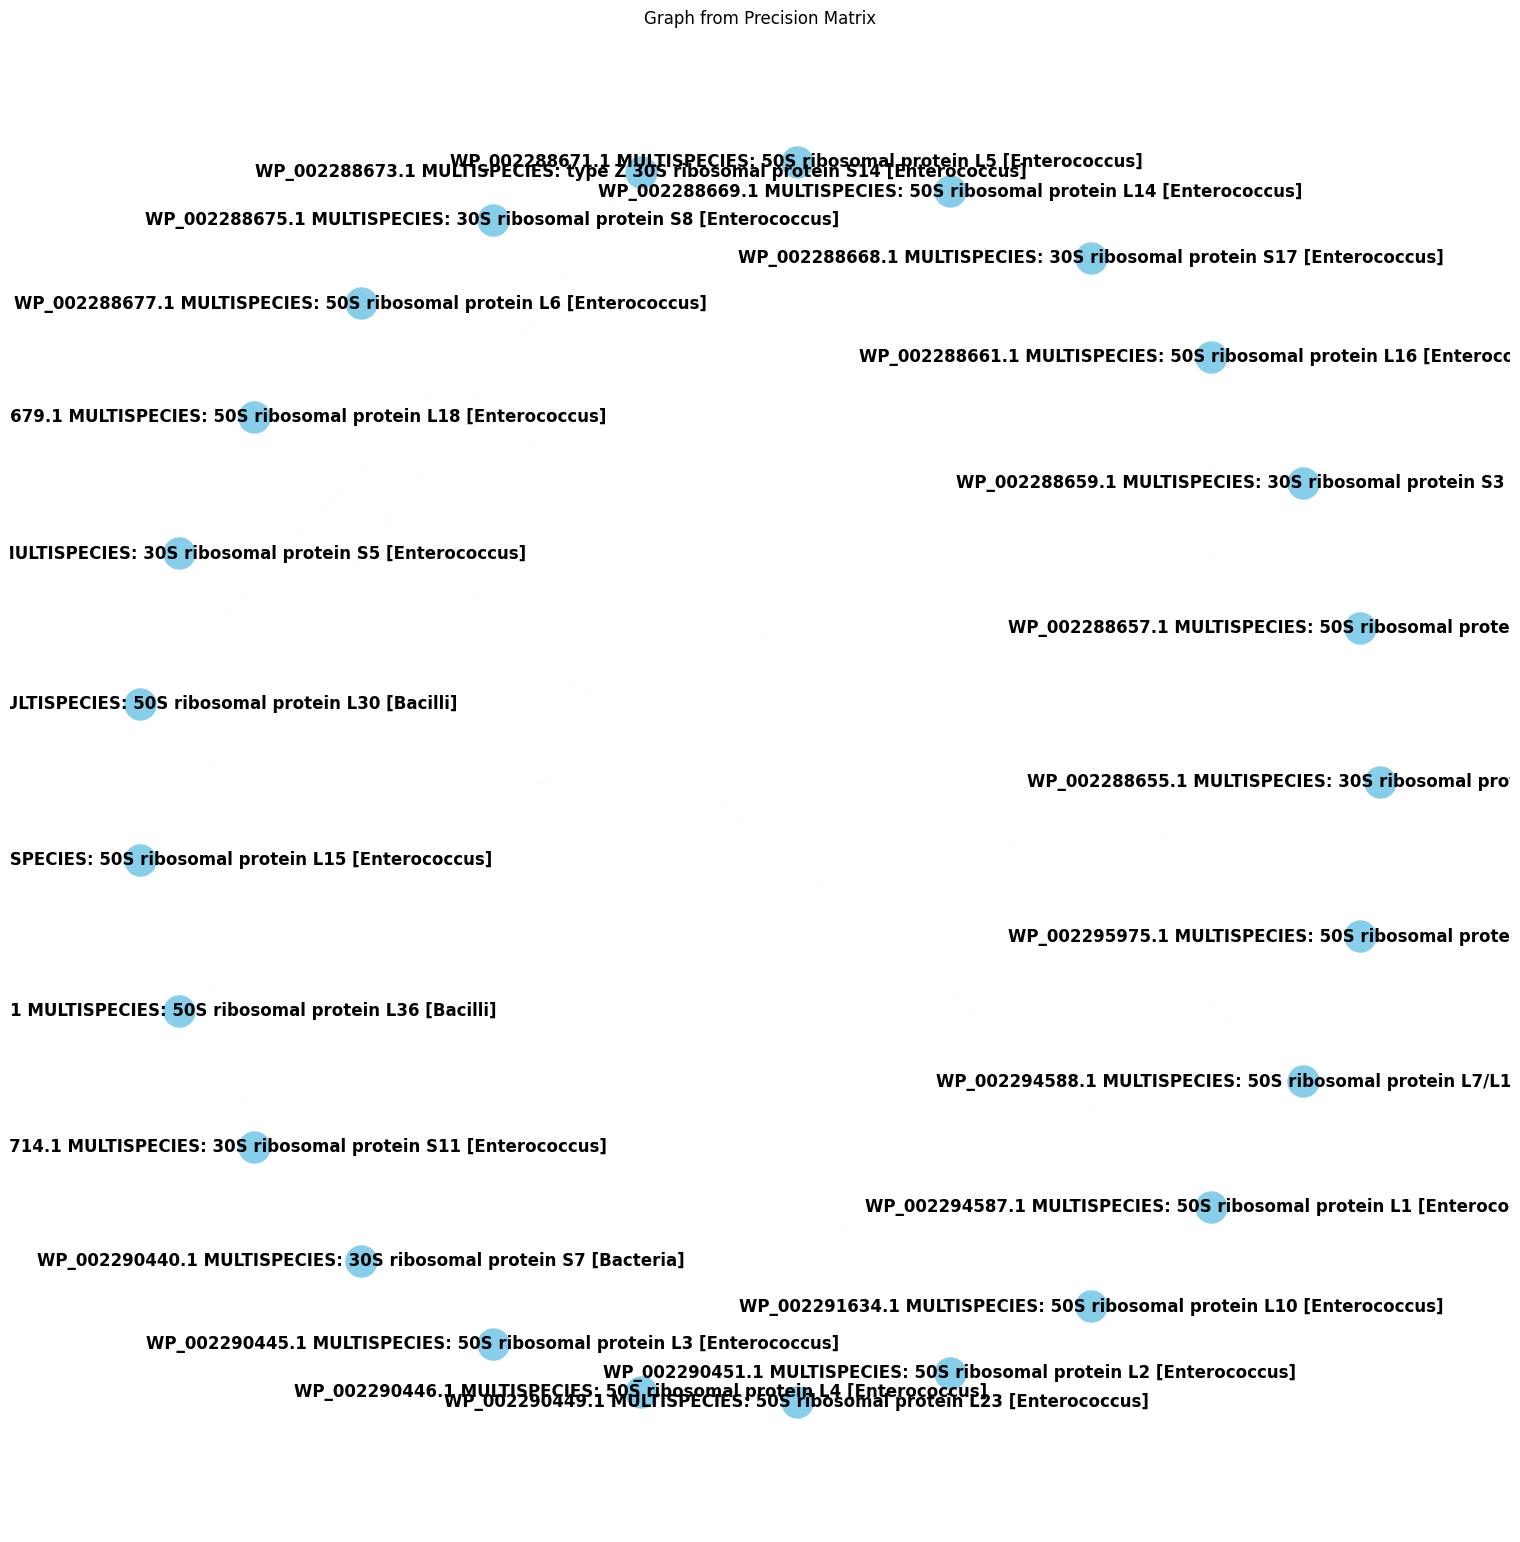

In [27]:
efm_G = nx.Graph()

# Add nodes to the graph
for idx, row in efm_rrna.var.iterrows():
    efm_G.add_node(row['protein_name'])

# Add edges to the graph based on the weights
n = len(efm_rrna.var)
for i in range(n):
    for j in range(i + 1, n):
        weight = efm_rrna_sol_latentcor[i, j]
        if weight != 0:
            efm_G.add_edge(efm_rrna.var.iloc[i]['protein_name'], efm_rrna.var.iloc[j]['protein_name'], weight=weight)

# Set edge colors based on weight sign
edge_colors = []
edge_widths = []
for edge in efm_G.edges(data=True):
    weight = edge[2]['weight']
    if weight > 0:
        edge_colors.append('red')  # Positive edge
    elif weight < 0:
        edge_colors.append('blue')  # Negative edge
    edge_widths.append(abs(weight) * 0.01)  # Scale width based on weight


# Draw the graph
pos = nx.circular_layout(efm_G)
plt.figure(figsize=(15, 15))
nx.draw(efm_G, pos, with_labels=True, node_size=500, node_color='skyblue', font_size=12, font_weight='bold', 
        edge_color=edge_colors, width=edge_widths)
plt.title('Graph from Precision Matrix')
plt.show()